In [1]:
import kagglehub
radmilasegen_dataset_path = kagglehub.dataset_download('radmilasegen/dataset-fin')

print('Data source import complete.')

Data source import complete.


In [2]:
import os
from glob import glob

BASE_PATH = "/kaggle/input/dataset-fin/new_ds"
CLASSES_PATH = os.path.join(BASE_PATH, "merged_classes.txt")

In [3]:
import os
import random
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.resnet import resnet50, ResNet50_Weights
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign
from torch.utils.data import Dataset, DataLoader

In [4]:
IMG_SIZE   = 256
BATCH_SIZE = 4
EPOCHS     = 10
LR         = 0.002

In [5]:
def load_classes(path=CLASSES_PATH):
    with open(path, "r") as f:
        return [line.strip() for line in f.readlines() if line.strip()]

In [6]:
def read_label(label_path):
    objs = []
    with open(label_path) as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls, x, y, w, h = map(float, parts)
            objs.append(dict(
                cls_id=int(cls),
                x_center=x,
                y_center=y,
                width=w,
                height=h
            ))
    return objs

In [7]:
def collect_samples(base_path=BASE_PATH):
    samples = []
    folders = sorted([f for f in os.listdir(BASE_PATH) if f.isdigit()])

    for folder in folders:
        img_dir   = os.path.join(BASE_PATH, folder, "images")
        depth_dir = os.path.join(BASE_PATH, folder, "depth")
        midas_dir = os.path.join(BASE_PATH, folder, "depth_midas")
        label_dir = os.path.join(BASE_PATH, folder, "labels")

        if not all(map(os.path.isdir, [img_dir, depth_dir, midas_dir, label_dir])):
            continue

        for img_path in glob(os.path.join(img_dir, "*.png")):
            name = os.path.basename(img_path)

            dR_path = os.path.join(depth_dir, name)
            dM_path = os.path.join(midas_dir, name)
            lb_path = os.path.join(label_dir, name.replace(".png", ".txt"))

            if not all(map(os.path.exists, [dR_path, dM_path, lb_path])):
                continue

            objs = read_label(lb_path)
            if len(objs) == 0:
                continue

            samples.append(dict(
                rgb=img_path,
                depth_real=dR_path,
                depth_midas=dM_path,
                objects=objs
            ))
    return samples

In [8]:
def compute_depth_min_max(samples):
    d_min, d_max = 1e9, -1e9
    for s in samples:
        dR = cv2.imread(s["depth_real"],  cv2.IMREAD_ANYDEPTH)
        dM = cv2.imread(s["depth_midas"], cv2.IMREAD_ANYDEPTH)
        if dR is None or dM is None:
            continue
        dR = dR.astype(np.float32)
        dM = dM.astype(np.float32)
        d_min = min(d_min, dR.min(), dM.min())
        d_max = max(d_max, dR.max(), dM.max())
    return d_min, d_max

In [9]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [10]:
class RGBRealMiDaSDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        item = self.samples[idx]

        rgb = cv2.imread(item["rgb"])
        dR  = cv2.imread(item["depth_real"],  cv2.IMREAD_ANYDEPTH)
        dM  = cv2.imread(item["depth_midas"], cv2.IMREAD_ANYDEPTH)

        if rgb is None or dR is None or dM is None:
            return self.__getitem__((idx + 1) % len(self.samples))

        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
        dR  = dR.astype(np.float32)
        dM  = dM.astype(np.float32)

        h0, w0 = rgb.shape[:2]

        scale = min(IMG_SIZE / h0, IMG_SIZE / w0)
        new_w, new_h = int(w0 * scale), int(h0 * scale)

        rgb_rs = cv2.resize(rgb, (new_w, new_h))
        dR_rs  = cv2.resize(dR,  (new_w, new_h))
        dM_rs  = cv2.resize(dM,  (new_w, new_h))

        pad_w, pad_h = IMG_SIZE - new_w, IMG_SIZE - new_h
        pad_l, pad_t = pad_w // 2, pad_h // 2

        rgb_pad = np.zeros((IMG_SIZE, IMG_SIZE, 3), np.uint8)
        dR_pad  = np.zeros((IMG_SIZE, IMG_SIZE), np.float32)
        dM_pad  = np.zeros((IMG_SIZE, IMG_SIZE), np.float32)

        rgb_pad[pad_t:pad_t+new_h, pad_l:pad_l+new_w] = rgb_rs
        dR_pad [pad_t:pad_t+new_h, pad_l:pad_l+new_w] = dR_rs
        dM_pad [pad_t:pad_t+new_h, pad_l:pad_l+new_w] = dM_rs

        rgb_norm = rgb_pad.astype(np.float32) / 255.0
        dR_norm  = (dR_pad - DEPTH_MIN) / (DEPTH_MAX - DEPTH_MIN + 1e-6)
        dM_norm  = (dM_pad - DEPTH_MIN) / (DEPTH_MAX - DEPTH_MIN + 1e-6)

        x = np.concatenate(
            [rgb_norm, dR_norm[..., None], dM_norm[..., None]],
            axis=2
        )
        x = torch.from_numpy(x).permute(2, 0, 1).float()

        boxes  = []
        labels = []

        for obj in item["objects"]:
            cx = obj["x_center"] * w0
            cy = obj["y_center"] * h0
            bw = obj["width"]  * w0
            bh = obj["height"] * h0

            x1 = (cx - bw / 2) * scale + pad_l
            y1 = (cy - bh / 2) * scale + pad_t
            x2 = (cx + bw / 2) * scale + pad_l
            y2 = (cy + bh / 2) * scale + pad_t

            boxes.append([x1, y1, x2, y2])
            labels.append(obj["cls_id"] + 1)

        boxes  = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
        }

        return x, target

In [11]:
class ConvStem(nn.Module):
    def __init__(self, ch_in):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(ch_in, 32, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU()
        )
    def forward(self, x):
        return self.net(x) 

In [12]:
class CrossModalSpatialAttention(nn.Module):
    def __init__(self, channels=64):
        super().__init__()
        self.att_conv = nn.Sequential(
            nn.Conv2d(channels*3, channels, 1),
            nn.ReLU(),
            nn.Conv2d(channels, 3, 1)
        )
    def forward(self, f_rgb, f_r, f_m):
        cat = torch.cat([f_rgb, f_r, f_m], dim=1)   
        logits = self.att_conv(cat)                
        weights = torch.softmax(logits, dim=1)      
        w_rgb = weights[:,0:1]
        w_r   = weights[:,1:2]
        w_m   = weights[:,2:3]
        fused = w_rgb * f_rgb + w_r * f_r + w_m * f_m
        return fused

In [13]:
class FiveChannelStem(nn.Module):
    def __init__(self):
        super().__init__()
        self.rgb_stem = ConvStem(3)
        self.r_stem   = ConvStem(1)
        self.m_stem   = ConvStem(1)
        self.att      = CrossModalSpatialAttention(channels=64)

    def forward(self, x):
        f_rgb = self.rgb_stem(x[:, :3])
        f_r   = self.r_stem  (x[:, 3:4])
        f_m   = self.m_stem  (x[:, 4:5])
        f_fused = self.att(f_rgb, f_r, f_m)
        return f_fused 

In [14]:
class RGBRM_Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.stem = FiveChannelStem()
        self.body = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.body.conv1 = nn.Conv2d(64, 64, 7, 2, 3, bias=False)

        for name, p in self.body.named_parameters():
            if "layer3" not in name and "layer4" not in name:
                p.requires_grad = False

        self.fpn = FeaturePyramidNetwork(
            [256, 512, 1024, 2048],
            256,
            extra_blocks=LastLevelMaxPool()
        )
        self.out_channels = 256

    def forward(self, x):
        x = self.stem(x)
        x = self.body.conv1(x)
        x = self.body.bn1(x)
        x = self.body.relu(x)
        x = self.body.maxpool(x)

        c2 = self.body.layer1(x)
        c3 = self.body.layer2(c2)
        c4 = self.body.layer3(c3)
        c5 = self.body.layer4(c4)

        feats = self.fpn({"0": c2, "1": c3, "2": c4, "3": c5})
        return feats

In [15]:
def show_test_predictions_5(model, test_samples, score_thresh=0.5):
    model.eval()
    chosen = random.sample(test_samples, min(5, len(test_samples)))

    for idx, sample in enumerate(chosen):
        print(f"\ntest sample {idx+1}")

        rgb = cv2.imread(sample["rgb"])
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB).astype(np.uint8)

        dR = cv2.imread(sample["depth_real"],  cv2.IMREAD_ANYDEPTH).astype(np.float32)
        dM = cv2.imread(sample["depth_midas"], cv2.IMREAD_ANYDEPTH).astype(np.float32)

        h0, w0 = rgb.shape[:2]

        scale = min(IMG_SIZE / h0, IMG_SIZE / w0)
        new_w, new_h = int(w0 * scale), int(h0 * scale)

        rgb_rs = cv2.resize(rgb, (new_w, new_h))
        dR_rs  = cv2.resize(dR,  (new_w, new_h))
        dM_rs  = cv2.resize(dM,  (new_w, new_h))

        pad_w = IMG_SIZE - new_w
        pad_h = IMG_SIZE - new_h
        pad_left = pad_w // 2
        pad_top  = pad_h // 2

        rgb_pad = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
        dR_pad  = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)
        dM_pad  = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)

        rgb_pad[pad_top:pad_top+new_h, pad_left:pad_left+new_w] = rgb_rs
        dR_pad [pad_top:pad_top+new_h, pad_left:pad_left+new_w] = dR_rs
        dM_pad [pad_top:pad_top+new_h, pad_left:pad_left+new_w] = dM_rs

        rgb_norm = rgb_pad / 255.0
        dR_norm  = (dR_pad - DEPTH_MIN) / (DEPTH_MAX - DEPTH_MIN + 1e-6)
        dM_norm  = (dM_pad - DEPTH_MIN) / (DEPTH_MAX - DEPTH_MIN + 1e-6)

        x = np.concatenate(
            [rgb_norm, dR_norm[..., None], dM_norm[..., None]],
            axis=2
        )

        x_t = torch.from_numpy(x).permute(2,0,1).unsqueeze(0).float().to(device)

        with torch.no_grad():
            out = model([x_t[0]])[0]

        boxes  = out["boxes"].cpu().numpy()
        labels = out["labels"].cpu().numpy()
        scores = out["scores"].cpu().numpy()

        vis = rgb_pad.copy()

        for box, lbl, sc in zip(boxes, labels, scores):
            if sc < score_thresh:
                continue

            x1,y1,x2,y2 = box.astype(int)
            cls_id = int(lbl) - 1

            if cls_id < 0 or cls_id >= len(CLASSES):
                continue

            name = CLASSES[cls_id]

            cv2.rectangle(vis, (x1,y1), (x2,y2), (255,0,0), 2)
            cv2.putText(
                vis,
                f"{name} {sc:.2f}",
                (x1, max(15, y1-5)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (255,0,0),
                2
            )

        plt.figure(figsize=(7,7))
        plt.title(f"Test Prediction {idx+1}")
        plt.imshow(vis)
        plt.axis("off")
        plt.show()

In [16]:
def box_iou(box1, box2):
    x1 = max(float(box1[0]), float(box2[0]))
    y1 = max(float(box1[1]), float(box2[1]))
    x2 = min(float(box1[2]), float(box2[2]))
    y2 = min(float(box1[3]), float(box2[3]))

    inter_w = max(0.0, x2 - x1)
    inter_h = max(0.0, y2 - y1)
    inter = inter_w * inter_h

    if inter <= 0.0:
        return 0.0

    area1 = max(0.0, float(box1[2]) - float(box1[0])) * max(0.0, float(box1[3]) - float(box1[1]))
    area2 = max(0.0, float(box2[2]) - float(box2[0])) * max(0.0, float(box2[3]) - float(box2[1]))
    union = area1 + area2 - inter
    if union <= 0.0:
        return 0.0

    return inter / union

In [17]:
@torch.no_grad()
def evaluate_detection(model, data_loader, class_names, device=None,
                    iou_thresh=0.5, score_thresh=0.5):
    if device is None:
        device = next(model.parameters()).device

    model.eval()

    num_classes = len(class_names)

    total_gt = 0 
    total_pred = 0
    total_tp = 0 

    iou_sum = 0.0
    iou_cnt = 0

    per_class_gt = [0] * num_classes
    per_class_pred = [0] * num_classes
    per_class_tp = [0] * num_classes
    per_class_iou_sum = [0.0] * num_classes
    per_class_iou_cnt = [0] * num_classes

    for images, targets in data_loader:
        images = [img.to(device) for img in images]

        outputs = model(images)

        for out, tgt in zip(outputs, targets):
            gt_boxes = tgt["boxes"].cpu().numpy()
            gt_labels = tgt["labels"].cpu().numpy() 

            total_gt += len(gt_boxes)
            for lbl in gt_labels:
                if 1 <= lbl <= num_classes:
                    per_class_gt[lbl - 1] += 1

            if len(gt_boxes) == 0:
                pred_scores = out["scores"].cpu().numpy()
                pred_labels = out["labels"].cpu().numpy()

                keep = pred_scores >= score_thresh
                pred_labels = pred_labels[keep]

                num_pred = len(pred_labels)
                total_pred += num_pred
                for lbl in pred_labels:
                    if 1 <= lbl <= num_classes:
                        per_class_pred[lbl - 1] += 1
                continue

            pred_boxes = out["boxes"].cpu().numpy()
            pred_labels = out["labels"].cpu().numpy()
            pred_scores = out["scores"].cpu().numpy()

            keep = pred_scores >= score_thresh
            pred_boxes = pred_boxes[keep]
            pred_labels = pred_labels[keep]
            pred_scores = pred_scores[keep]

            total_pred += len(pred_boxes)
            for lbl in pred_labels:
                if 1 <= lbl <= num_classes:
                    per_class_pred[lbl - 1] += 1

            matched_gt = np.zeros(len(gt_boxes), dtype=bool)

            order = np.argsort(-pred_scores)
            for p_idx in order:
                p_box = pred_boxes[p_idx]
                p_lbl = pred_labels[p_idx]
                if not (1 <= p_lbl <= num_classes):
                    continue

                best_iou = 0.0
                best_gt_idx = -1

                for g_idx, (g_box, g_lbl) in enumerate(zip(gt_boxes, gt_labels)):
                    if matched_gt[g_idx]:
                        continue
                    if g_lbl != p_lbl:
                        continue

                    iou = box_iou(p_box, g_box)
                    if iou > best_iou:
                        best_iou = iou
                        best_gt_idx = g_idx

                if best_gt_idx >= 0 and best_iou >= iou_thresh:
                    matched_gt[best_gt_idx] = True
                    total_tp += 1

                    iou_sum += best_iou
                    iou_cnt += 1

                    c = p_lbl - 1
                    per_class_tp[c] += 1
                    per_class_iou_sum[c] += best_iou
                    per_class_iou_cnt[c] += 1
                else:
                    pass

    def safe_div(a, b):
        return a / b if b > 0 else 0.0

    overall_precision = safe_div(total_tp, total_pred)
    overall_recall = safe_div(total_tp, total_gt)
    overall_f1 = safe_div(2 * overall_precision * overall_recall,
                        overall_precision + overall_recall)
    overall_iou = safe_div(iou_sum, iou_cnt)

    print("Detection metrics: IoU >= {:.2f}, score >= {:.2f}".format(
        iou_thresh, score_thresh))
    print(f"  GT: {total_gt}, Pred: {total_pred}, TP: {total_tp}")
    print(f"Precision: {overall_precision:.4f}")
    print(f"Recall:    {overall_recall:.4f}")
    print(f"F1-score:  {overall_f1:.4f}")
    print(f"Avg IoU by TP: {overall_iou:.4f}")

    print("\nMetrics by classes:")
    for idx, name in enumerate(class_names):
        tp = per_class_tp[idx]
        gt = per_class_gt[idx]
        pred = per_class_pred[idx]
        prec = safe_div(tp, pred)
        rec = safe_div(tp, gt)
        f1 = safe_div(2 * prec * rec, prec + rec)
        avg_iou = safe_div(per_class_iou_sum[idx], per_class_iou_cnt[idx])

        print(f"[{idx+1}] {name}:")
        print(f"  GT: {gt}, Pred: {pred}, TP: {tp}")
        print(f"  Precision: {prec:.4f}")
        print(f"  Recall:    {rec:.4f}")
        print(f"  F1-score:  {f1:.4f}")
        print(f"  Avg IoU:   {avg_iou:.4f}")

Device: cuda
Classes: ['bottle', 'box', 'cola', 'container', 'cube', 'duck', 'pods', 'scissors', 'sphere', 'tape', 'tor']
Valid data count: 3117
Example sample: {'rgb': '/kaggle/input/dataset-fin/new_ds/1/images/00105.png', 'depth_real': '/kaggle/input/dataset-fin/new_ds/1/depth/00105.png', 'depth_midas': '/kaggle/input/dataset-fin/new_ds/1/depth_midas/00105.png', 'objects': [{'cls_id': 6, 'x_center': 0.6138095238095238, 'y_center': 0.8499470899470899, 'width': 0.14952380952380978, 'height': 0.2979894179894178}]}
DEPTH_MIN, DEPTH_MAX: 0.0 65535.0
Train size: 585 Test size: 780


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 225MB/s]


Model created.
Epoch 1/5 | train_loss = 0.3296
Epoch 2/5 | train_loss = 0.2523
Epoch 3/5 | train_loss = 0.2339
Epoch 4/5 | train_loss = 0.2036
Epoch 5/5 | train_loss = 0.1728
Model saved: rgbd_fasterrcnn_crossmodal_8x8.pth

test sample 1


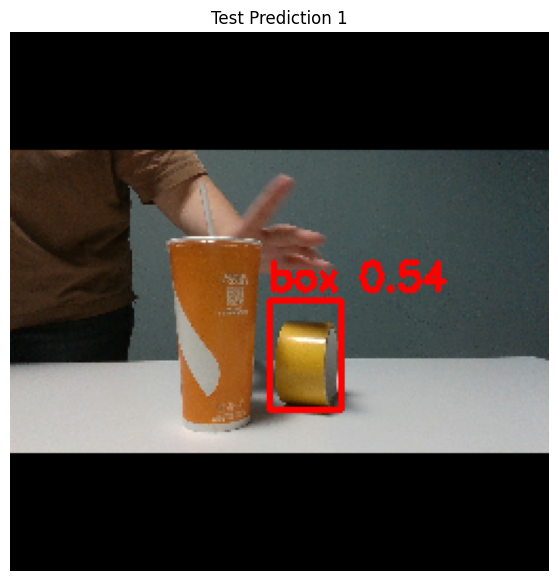


test sample 2


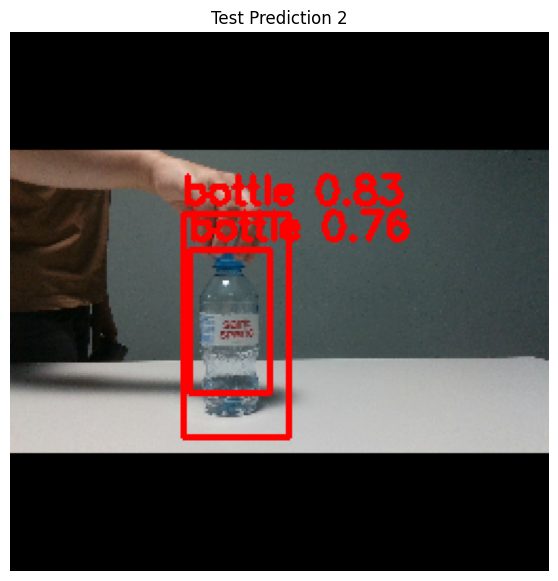


test sample 3


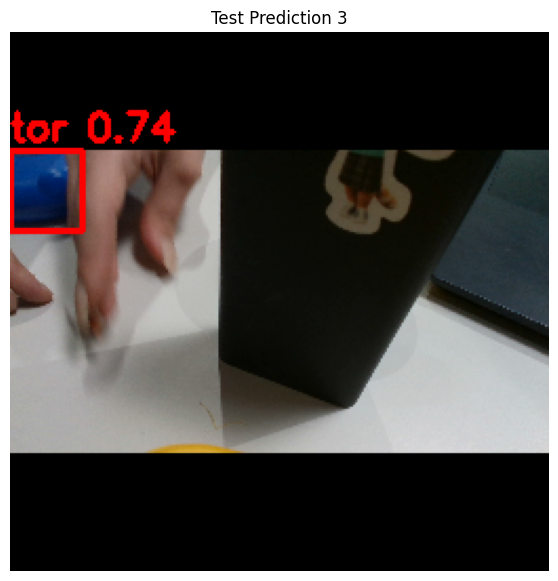


test sample 4


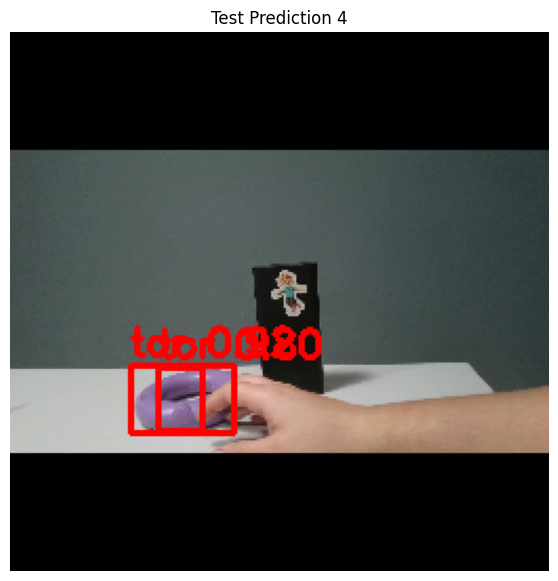


test sample 5


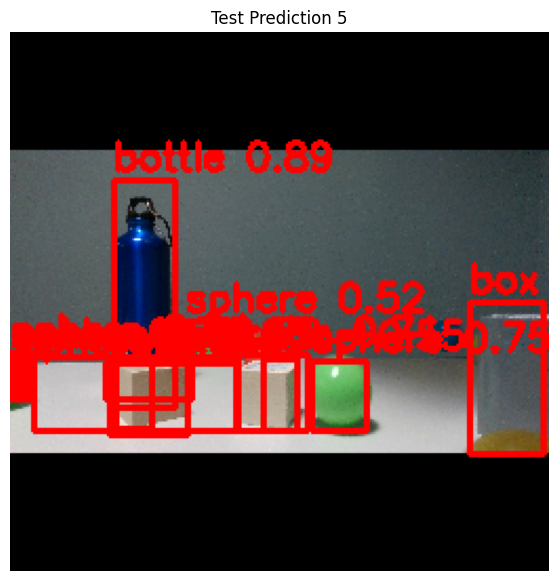

Detection metrics: IoU >= 0.50, score >= 0.50
  GT: 1922, Pred: 2681, TP: 1341
Precision: 0.5002
Recall:    0.6977
F1-score:  0.5827
Avg IoU by TP: 0.7791

Metrics by classes:
[1] bottle:
  GT: 154, Pred: 179, TP: 91
  Precision: 0.5084
  Recall:    0.5909
  F1-score:  0.5465
  Avg IoU:   0.6682
[2] box:
  GT: 212, Pred: 270, TP: 176
  Precision: 0.6519
  Recall:    0.8302
  F1-score:  0.7303
  Avg IoU:   0.7949
[3] cola:
  GT: 71, Pred: 0, TP: 0
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000
  Avg IoU:   0.0000
[4] container:
  GT: 20, Pred: 0, TP: 0
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000
  Avg IoU:   0.0000
[5] cube:
  GT: 256, Pred: 494, TP: 214
  Precision: 0.4332
  Recall:    0.8359
  F1-score:  0.5707
  Avg IoU:   0.7958
[6] duck:
  GT: 164, Pred: 278, TP: 142
  Precision: 0.5108
  Recall:    0.8659
  F1-score:  0.6425
  Avg IoU:   0.8198
[7] pods:
  GT: 52, Pred: 59, TP: 33
  Precision: 0.5593
  Recall:    0.6346
  F1-score:  0.5946
  Avg IoU:  

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

CLASSES = load_classes()
num_classes = len(CLASSES)
num_classes_with_bg = num_classes + 1
print("Classes:", CLASSES)

samples = collect_samples()
print("Valid data count:", len(samples))
print("Example sample:", samples[0])

DEPTH_MIN, DEPTH_MAX = compute_depth_min_max(samples)
print("DEPTH_MIN, DEPTH_MAX:", DEPTH_MIN, DEPTH_MAX)

random.shuffle(samples)

n_total = len(samples)
n_train = int(0.75 * n_total)

train_samples = samples[:n_train]
test_samples  = samples[n_train:]

train_loader = DataLoader(
    RGBRealMiDaSDataset(train_samples),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    RGBRealMiDaSDataset(test_samples),
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

print("Train size:", len(train_loader), "Test size:", len(test_loader))

backbone = RGBRM_Backbone().to(device)

anchor_generator = AnchorGenerator(
    sizes=((32,), (64,), (128,), (256,), (512,)),
    aspect_ratios=((0.5, 1.0, 2.0),) * 5,
)

roi_pooler = MultiScaleRoIAlign(
    featmap_names=["0", "1", "2", "3", "pool"],
    output_size=7,
    sampling_ratio=2,
)

model = FasterRCNN(
    backbone,
    num_classes=num_classes_with_bg,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler,
    image_mean=[0.5] * 5,
    image_std=[0.25] * 5
).to(device)

print("Model created.")

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=LR,
    momentum=0.9,
    weight_decay=1e-4
)

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0.0
    n_batches = 0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
        n_batches += 1

    print(f"Epoch {epoch}/{EPOCHS} | train_loss = {total_loss / n_batches:.4f}")

torch.save(model.state_dict(), "rgbdd_fasterrcnn_crossmodal_8x8.pth")
print("Model saved: rgbdd_fasterrcnn_crossmodal_8x8.pth")

show_test_predictions_5(model, test_samples, score_thresh=0.75)

evaluate_detection(model, test_loader, CLASSES, device=device, iou_thresh=0.75, score_thresh=0.75)